In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
import os
import pathlib
import zipfile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential


# When using the Sequential API we need to remember that when we are having a single layer then we are passing the input inside the brackets and if its a model like taht of Data augnmentation or base_model then we pass input inside the brackets

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [22]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-07-05 07:06:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-05 07:06:07 (95.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
!wget 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'

--2023-07-04 17:23:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   277MB/s    in 0.6s    

2023-07-04 17:23:18 (277 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
zipref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zipref.extractall()
zipref.close()

In [ ]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 10 director

In [ ]:
# Creating paths
train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

In [ ]:
# Image preprocessing
''' we will be using improved vesrion of ImageDataGenerator'''
# tf.keras.preprocessing.image_dataset_from_directory  (Generates a tf.data.Dataset from image files in a directory.)
'''hat yields batches of images from the subdirectories '''

IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                      image_size = IMG_SIZE,
                                                                      label_mode = 'categorical',
                                                                      batch_size = 32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


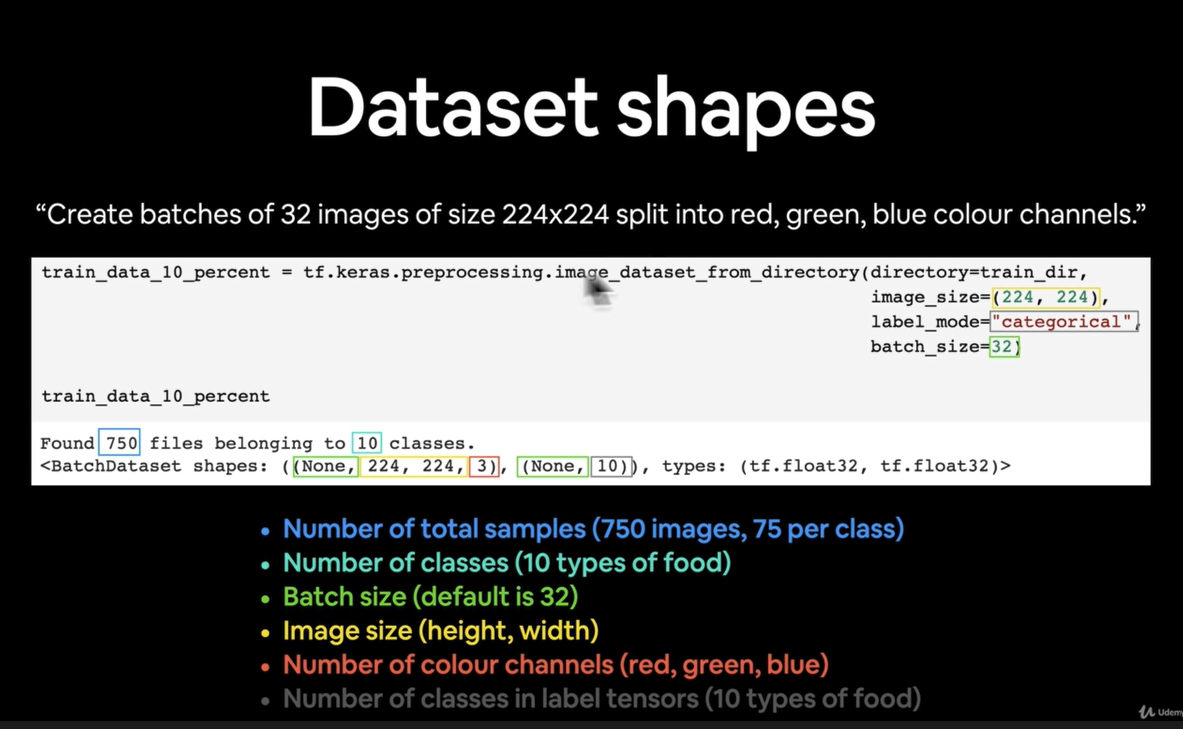

In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
train_data_10_percent.num_classes
'''hat yields batches of images from the subdirectories '''
# Thats why num_classes() doent work on it

AttributeError: ignored

In [ ]:
# See an example of a batch of our data
for images, labels in train_data_10_percent.take(1): # the taking is going to unravel a batch which means we get images and labels --> as a tuple of images and labels
  print(images, labels)

tf.Tensor(
[[[[1.39500000e+02 1.23357147e+02 6.25714264e+01]
   [1.35994888e+02 1.07755096e+02 5.25204048e+01]
   [1.39785706e+02 1.01637749e+02 5.10102005e+01]
   ...
   [2.05719482e+02 8.57194901e+01 1.32148010e+02]
   [2.03454132e+02 8.23112564e+01 1.27239815e+02]
   [2.17790787e+02 9.12499466e+01 1.34846848e+02]]

  [[1.44556122e+02 1.15984695e+02 6.33418388e+01]
   [1.04249992e+02 6.76836624e+01 2.32448883e+01]
   [9.65918350e+01 5.65663223e+01 1.99795895e+01]
   ...
   [1.84382660e+02 6.82959213e+01 1.13739754e+02]
   [1.85290863e+02 6.19489555e+01 1.08071426e+02]
   [2.03826874e+02 7.16380615e+01 1.19760445e+02]]

  [[1.32040802e+02 9.54693832e+01 5.36122398e+01]
   [9.62806091e+01 5.83928528e+01 2.76377544e+01]
   [8.36938705e+01 4.76530609e+01 2.60306110e+01]
   ...
   [1.72729248e+02 6.05098190e+01 1.04678146e+02]
   [1.73780609e+02 5.02090797e+01 9.74234009e+01]
   [1.79097290e+02 4.21533203e+01 9.25870361e+01]]

  ...

  [[8.54388885e+01 5.85919380e+01 2.87960339e+01]
   [9

In [ ]:
# we know our network likes input between 0 an 1 so we need to standardise the inputs

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [ ]:
# Creating the base model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top = False)  #the top layer is the fully connected output layer which predicts the labels

#Freeze the base_model
base_model.trainable = False

#create inputs to our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name = "input_layer")

#(optional) if we are using RasNet we need to normalize our inputs
#earlier we used to normalize our data with the help of ImageDataGenerator(rescale = 1./255)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

#passing the inputs to the base models
x = base_model(inputs)
print(f"Shape after passing inouts through base model: {x.shape}")

# average pool the outputs of the base model (aggregates all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pooling_layer")(x)
print(f"Shape after Global avg pooling 2D: {x.shape}")

#Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

#Combine the input with the output in the model
model_0 = tf.keras.Model(inputs, outputs)

#compile the model
model_0.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = "Adam",
                metrics = ["accuracy"])

# Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = "transfer_learning", experiment_name = "10_percent_feature_extraction")]
                                 )


16705208/16705208 [==============================] - 0s 0us/step


Shape after passing inouts through base model: (None, 7, 7, 1280)
Shape after Global avg pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230621-113005
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.8489 - accuracy: 0.4307

KeyboardInterrupt: ignored

we can use both the tensorhub and the kerasAPI depending on our need

In [ ]:
# evaluate on full dataset
model_0.evaluate(test_data)

In [ ]:
#Check the layers in our base model
for layers_number, layers in enumerate(base_model.layers):
  print(layers_number, layers.name)

In [ ]:
base_model.summary()

In [ ]:
model_0.summary()

In [ ]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [ ]:
tf.random.set_seed(42)

input_shape = (1, 4, 4, 3)

input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

global_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_tensor}\n")

In [ ]:
tf.reduce_mean(input_tensor, axis = [1,2]) #this does similar work as

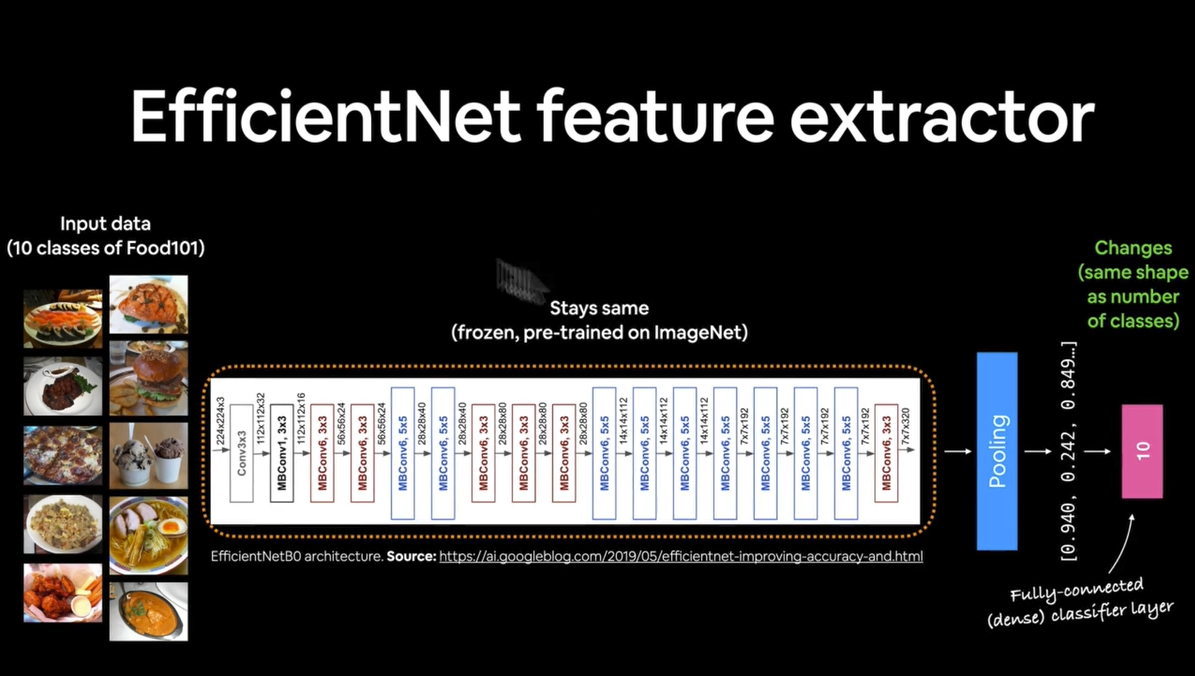

## Running a series of transfer learning experiments

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-06-21 15:55:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  64.6MB/s    in 2.0s    

2023-06-21 15:55:44 (64.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
zip_ref_1 = zipfile.ZipFile("10_food_classes_1_percent.zip")
zip_ref_1.extractall()
zip_ref_1.close()

In [ ]:
train_dir_1_percent = "/content/10_food_classes_1_percent/train"
test_dir = "/content/10_food_classes_1_percent/test"


In [ ]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_1_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [ ]:
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = 32)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          label_mode = "categorical",
                                                                          image_size = IMG_SIZE,
                                                                          batch_size = 32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## adding data augmentation right into the model

Earlier we used ImageDataGenerator for data augmentataion but now we will use a `tf.keras.layers()` we will be taking the help of the Sequential[]

### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU[ImageDataGenerator] (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - flips image on horizontal or vertical axis.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - randomly rotates image by a specified amount.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - randomly zooms into an image by specified amount.
* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - randomly shifts image height by a specified amount.
* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - randomly shifts image width by a specified amount.
* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.

There are more option but these will do for now.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
# ], name ="data_augmentation")

In [ ]:
# display a randomly chosen image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
# print(target_class)
target_dir = "/content/10_food_classes_1_percent/train/" + target_class
# print(target_dir)
random_images = random.choice(os.listdir(target_dir))
# print(random_images)
random_image_path = target_dir + '/' + random_images
# print(random_image_path)

img = mpimg.imread(random_image_path)
# print(img)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

augmented_image = data_augmentation(tf.expand_dims(img, axis = 0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()# we need to do this as in the above code we have used our figure so we need to create a new figure
#print(augmented_image) # here we can see that the value are not normalised thus we need to divide by 255.
plt.imshow(tf.squeeze(augmented_image/255.))
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

NameError: ignored

In [ ]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
input_shape = (224,224,3)

#creating base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#creating input layers
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Add in data augmentation Sequential model as a layer
x = base_model(x, training = False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model with inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data_1_percent,
                    validation_steps=int(0.25* len(test_data_1_percent)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

16705208/16705208 [==============================] - 0s 0us/step


NameError: ignored

In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
base_model.summary()

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 8s 91ms/step - loss: 1.7405 - accuracy: 0.5172


[1.7404882907867432, 0.5171999931335449]

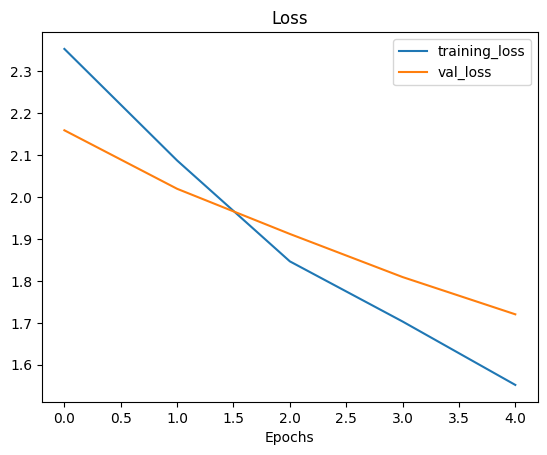

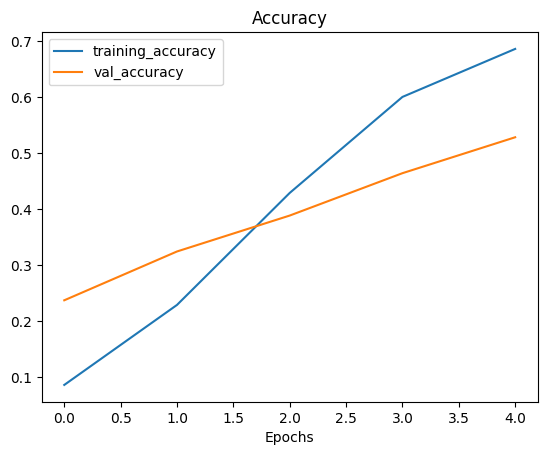

In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [ ]:
train_dir_10_percent = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/train"

In [ ]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = (224,224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size= (224, 224))


Found 750 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name = "Data_augmentation")

Input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = Input_shape, name = "Input_layer")

x = data_augmentation(inputs)
x = base_model(x , training = False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])




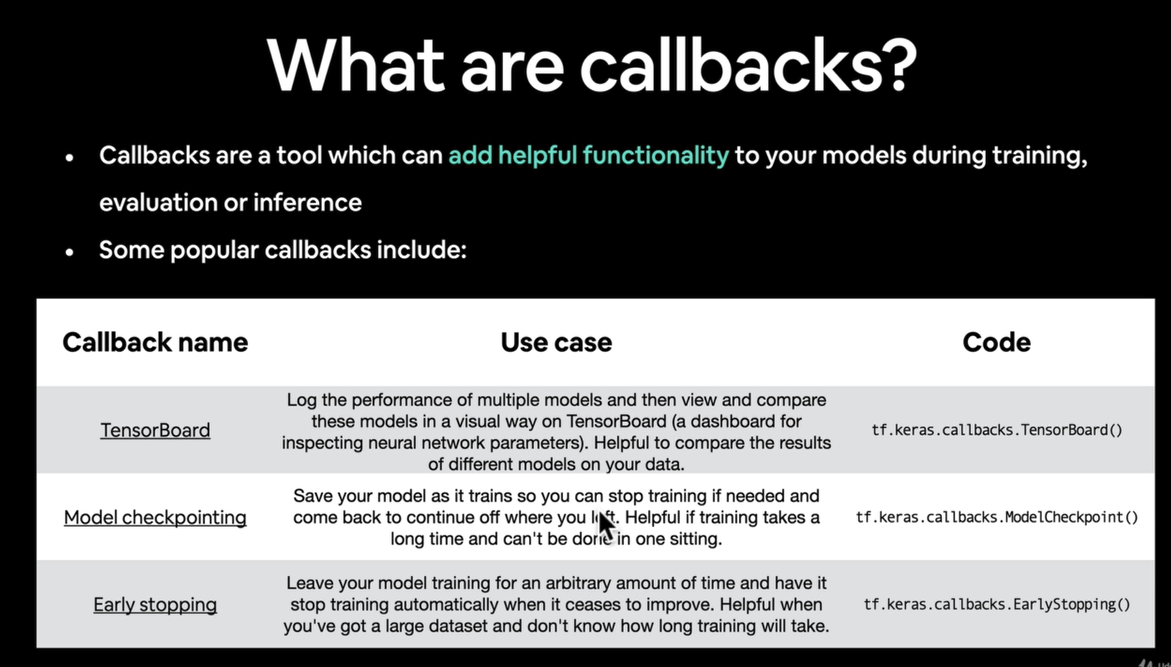

## Creating Model Checkpoint callbacks

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In [ ]:
# we first need checkpoint path

# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights_checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model'sweights only
checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                          save_weights = True,
                                                          save_best_only = False,
                                                          save_frequency = "epochs",
                                                          verbose = 1)

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callbacks])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230704-175447
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.4842 - accuracy: 0.6333
Epoch 1: saving model to ten_percent_model_checkpoints_weights_checkpoint.ckpt


TypeError: ignored

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

In [ ]:
model2.load_weights(checkpoint_path)
loaded_model_results = model_2.evaluate(test_data)

NameError: ignored

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_model_results))

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)

In [ ]:
model_2.layers

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [ ]:
for layers, layer_name in enumerate(base_model.layers):
  print(layers, layer_name.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# to fine tune we can do is just by first setting the base model trainavble = true

base_model.trainable = True

for layers in base_model.layers[:-10]: #technically when we say the last layers we mean the one near output layer
  base_model.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
fine_tune_epochs = initial_epoch = 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

NameError: ignored

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.



In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-07-05 06:00:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.128.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  39.6MB/s    in 13s     

2023-07-05 06:00:27 (37.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [4]:
import zipfile

zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

In [7]:
import os

for dirpath, dirname, filename in os.walk('10_food_classes_all_data'):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [54]:
train_100_percent_dir = "/content/10_food_classes_all_data/train"
test_100_dir = "/content/10_food_classes_all_data/test"

In [27]:
train_data = tf.keras.utils.image_dataset_from_directory(train_100_percent_dir,
                                                        label_mode="categorical",
                                                        batch_size = 32,
                                                        image_size = (224,224))

test_data = tf.keras.utils.image_dataset_from_directory(test_100_dir,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = (224, 224))

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [21]:
#augmenting data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
], name = 'data_augmentation')

In [28]:
# Making the the model

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Fine tuning code
base_model.trainable = False

# Making input layer

inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compiling the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])

model_history = model.fit(train_data,
                          epochs = 10,
                          batch_size = 32,
                          steps_per_epoch = len(train_data),
                          validation_data = test_data,
                          validation_steps = int(0.25 * len(test_data)),
                          callbacks = [create_tensorboard_callback("transfer_learning", "100_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/100_percent_feature_extract/20230705-071340
Epoch 1/10
235/235 [==============================] - 72s 274ms/step - loss: 1.9869 - accuracy: 0.3657 - val_loss: 1.5036 - val_accuracy: 0.6743
Epoch 2/10
235/235 [==============================] - 54s 227ms/step - loss: 1.4163 - accuracy: 0.6640 - val_loss: 1.0512 - val_accuracy: 0.8059
Epoch 3/10
235/235 [==============================] - 53s 221ms/step - loss: 1.1380 - accuracy: 0.7225 - val_loss: 0.8483 - val_accuracy: 0.8125
Epoch 4/10
235/235 [==============================] - 47s 197ms/step - loss: 0.9760 - accuracy: 0.7513 - val_loss: 0.7078 - val_accuracy: 0.8257
Epoch 5/10
235/235 [==============================] - 46s 193ms/step - loss: 0.8807 - accuracy: 0.7671 - val_loss: 0.6499 - val_accuracy: 0.8355
Epoch 6/10
235/235 [==============================] - 42s 174ms/step - loss: 0.8134 - accuracy: 0.7735 - val_loss: 0.5969 - val_accuracy: 0.8454
Epoch 7/10
235/235 [===============

/content/10_food_classes_all_data/train/pizza/1069629.jpg


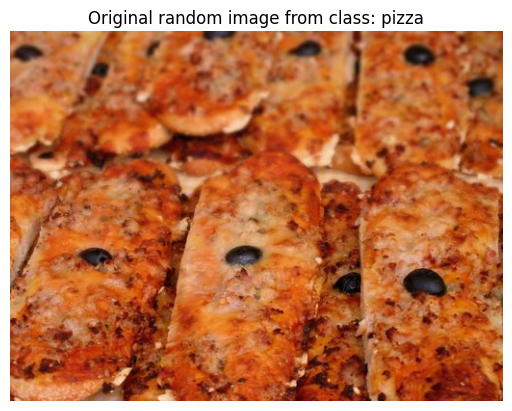

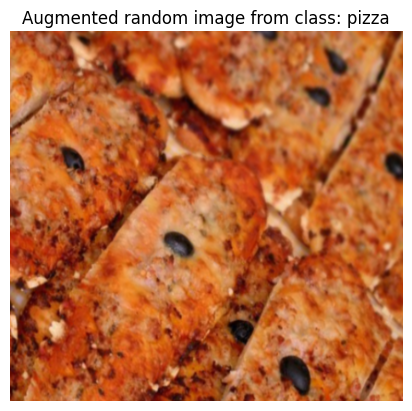

In [75]:
#View a Random image from the dataset

import os
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def show_real_and_aug_img(train_data_file): # takes the dataset as input (not the string path)
  random_dir = random.choice(train_data_file.class_names)
  # print(random_dir)
  target_class = train_100_percent_dir + '/' + random_dir
  # print(target_dir)
  random_img = random.choice(os.listdir(target_class)) # os.listdir() method in python is used to get the list of all files and directories in the specified directory.
  # print(random_img)
  random_img_path = target_class + '/' + random_img
  print(random_img_path)
  image = mpimg.imread(random_img_path)
  plt.imshow(image)
  plt.title(f"Original random image from class: {random_dir}")
  plt.axis(False); # turn off the axes


  # Augmented data
  augmented_img = data_augmentation(tf.expand_dims(image, axis=0)) # data augmentation model requires shape (None, height, width, 3)
  plt.figure()
  plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
  plt.title(f"Augmented random image from class: {random_dir}")
  plt.axis(False);


show_real_and_aug_img(train_data)

In [30]:
model.layers

In [33]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

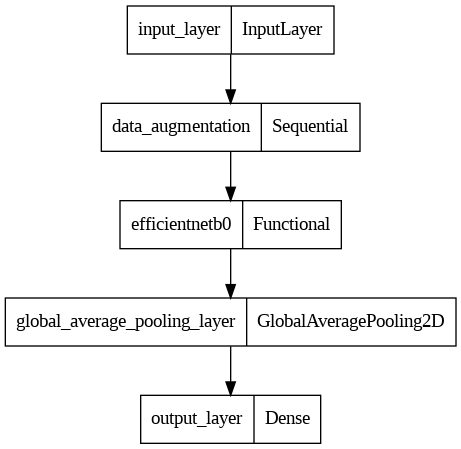

In [36]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [37]:
for layer_num, layer in enumerate(model.layers):
  print(layer_num, layer.name)

0 input_layer
1 data_augmentation
2 efficientnetb0
3 global_average_pooling_layer
4 output_layer


In [38]:
for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer.name)

0 input_12
1 rescaling_22
2 normalization_11
3 rescaling_23
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_acti

##Fine Tuning the Data

In [41]:
base_model.trainable = True

#we wish to train the last 10 layers in fine tuning
for layers in base_model.layers[ : -10]:
  layers.trainable = True


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["accuracy"])

In [45]:
initial_epochs = 10
fine_tuning_epochs = initial_epochs + 5

model_fine_tuned_history = model.fit(train_data,
                                     batch_size = 32,
                                     epochs = fine_tuning_epochs,
                                     steps_per_epoch = len(train_data),
                                     initial_epoch = model_history.epoch[-1],
                                     validation_data = test_data,
                                     validation_steps= int(0.25*(len(test_data))),
                                     callbacks= [create_tensorboard_callback("transfer_learning", "100_percent_fine_tuning")]
                                     )

Saving TensorBoard log files to: transfer_learning/100_percent_fine_tuning/20230705-081703
Epoch 10/15
235/235 [==============================] - 258s 1s/step - loss: 0.5259 - accuracy: 0.8347 - val_loss: 0.2827 - val_accuracy: 0.8964
Epoch 11/15
235/235 [==============================] - 188s 798ms/step - loss: 0.3474 - accuracy: 0.8861 - val_loss: 0.2323 - val_accuracy: 0.9128
Epoch 12/15
235/235 [==============================] - 163s 692ms/step - loss: 0.2621 - accuracy: 0.9140 - val_loss: 0.2983 - val_accuracy: 0.9095
Epoch 13/15
235/235 [==============================] - 153s 649ms/step - loss: 0.1929 - accuracy: 0.9343 - val_loss: 0.1999 - val_accuracy: 0.9276
Epoch 14/15
235/235 [==============================] - 138s 587ms/step - loss: 0.1472 - accuracy: 0.9520 - val_loss: 0.2176 - val_accuracy: 0.9293
Epoch 15/15
235/235 [==============================] - 135s 568ms/step - loss: 0.1204 - accuracy: 0.9591 - val_loss: 0.2322 - val_accuracy: 0.9227


In [78]:
model.evaluate(test_data)

79/79 [==============================] - 8s 92ms/step - loss: 0.2518 - accuracy: 0.9228


[0.2517729103565216, 0.9228000044822693]

In [ ]:
import pandas

